In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mem_util = pd.read_csv("mem_util.csv")
df_mem_cache = pd.read_csv("mem_cache.csv")
df_mem_available = pd.read_csv("mem_available.csv")


df_baseline_mem_util= pd.read_csv("../../baseline/memory related/mem_util.csv")
df_baseline_mem_cache= pd.read_csv("../../baseline/memory related/mem_cache.csv")
df_baseline_mem_available = pd.read_csv("../../baseline/memory related/mem_available.csv")


df_mem_util["source"] = "NETLOSS"
df_mem_cache["source"] = "NETLOSS"
df_mem_available["source"] = "NETLOSS"

df_baseline_mem_util["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_available["source"] = "BASELINE"


df_mem_util["Time"] = pd.to_datetime(df_mem_util["Time"])
df_mem_cache["Time"] = pd.to_datetime(df_mem_cache["Time"])
df_mem_available["Time"] = pd.to_datetime(df_mem_available["Time"])

df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])


delay = 30
duration = 50

## mem utilization

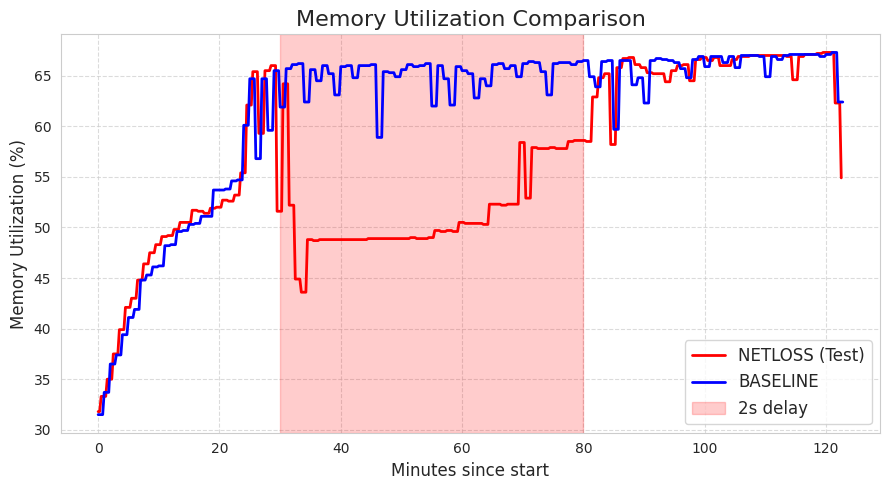

In [ ]:
df_mem_util["Minutes"] = (df_mem_util["Time"] - df_mem_util["Time"].min()).dt.total_seconds() / 60
df_baseline_mem_util["Minutes"] = (df_baseline_mem_util["Time"] - df_baseline_mem_util["Time"].min()).dt.total_seconds() / 60

plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")

plt.plot(df_mem_util["Minutes"], df_mem_util["mem_util"], 
         label="NETLOSS (Test)", color='red', linewidth=2)
plt.plot(df_baseline_mem_util["Minutes"], df_baseline_mem_util["mem_util"], 
         label="BASELINE", color='blue', linewidth=2)

plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="2s delay")

plt.title("Memory Utilization Comparison", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Memory Utilization (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()


## mem cache

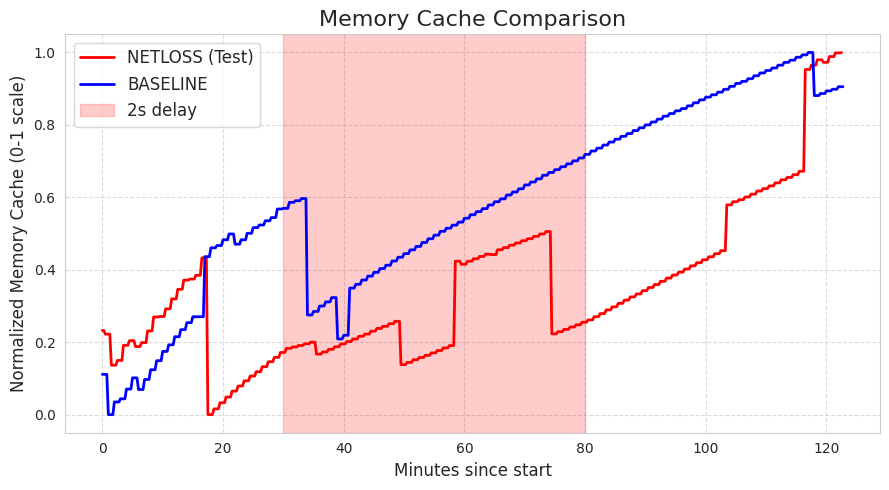

In [3]:
df_mem_cache['Time'] = pd.to_datetime(df_mem_cache['Time'])
df_baseline_mem_cache['Time'] = pd.to_datetime(df_baseline_mem_cache['Time'])

df_mem_cache["Minutes"] = (df_mem_cache["Time"] - df_mem_cache["Time"].min()).dt.total_seconds() / 60
df_baseline_mem_cache["Minutes"] = (df_baseline_mem_cache["Time"] - df_baseline_mem_cache["Time"].min()).dt.total_seconds() / 60

def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return series * 0

df_mem_cache["mem_cache_normalized"] = normalize_series(df_mem_cache["mem_cache"])
df_baseline_mem_cache["mem_cache_normalized"] = normalize_series(df_baseline_mem_cache["mem_cache"])

delay = 30  # 30 minutes (1800 seconds)
duration = 50  # 50 minutes (3000 seconds)

plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")

plt.plot(df_mem_cache["Minutes"], df_mem_cache["mem_cache_normalized"], 
         label="NETLOSS (Test)", color='red', linewidth=2)
plt.plot(df_baseline_mem_cache["Minutes"], df_baseline_mem_cache["mem_cache_normalized"], 
         label="BASELINE", color='blue', linewidth=2)

plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="2s delay")
plt.title("Memory Cache Comparison", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Normalized Memory Cache (0-1 scale)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()


## memory available

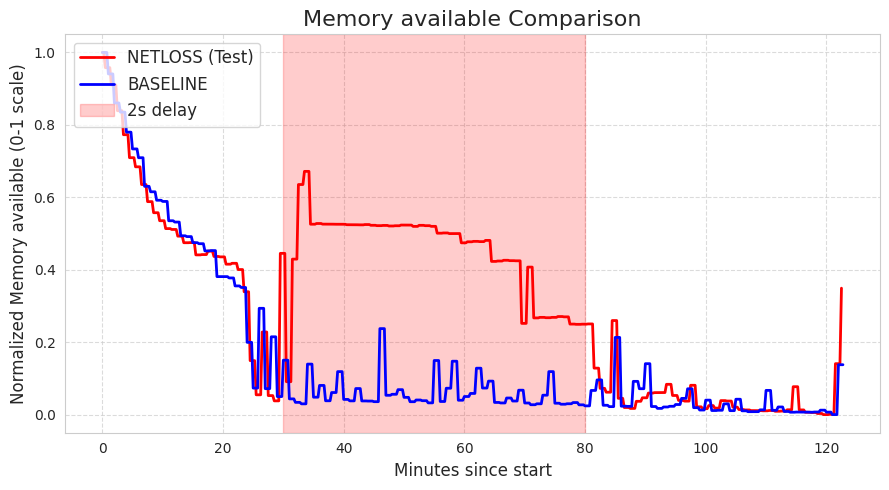

In [4]:
df_mem_available['Time'] = pd.to_datetime(df_mem_available['Time'])
df_baseline_mem_available['Time'] = pd.to_datetime(df_baseline_mem_available['Time'])

df_mem_available["Minutes"] = (df_mem_available["Time"] - df_mem_available["Time"].min()).dt.total_seconds() / 60
df_baseline_mem_available["Minutes"] = (df_baseline_mem_available["Time"] - df_baseline_mem_available["Time"].min()).dt.total_seconds() / 60

def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return series * 0

df_mem_available["mem_available_normalized"] = normalize_series(df_mem_available["mem_available"])
df_baseline_mem_available["mem_available_normalized"] = normalize_series(df_baseline_mem_available["mem_available"])

plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")

plt.plot(df_mem_available["Minutes"], df_mem_available["mem_available_normalized"], 
         label="NETLOSS (Test)", color='red', linewidth=2)
plt.plot(df_baseline_mem_available["Minutes"], df_baseline_mem_available["mem_available_normalized"], 
         label="BASELINE", color='blue', linewidth=2)

plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="2s delay")
plt.title("Memory available Comparison", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Normalized Memory available (0-1 scale)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
